# Sementic segmentation

In [1]:
#################
### Libraries ###
#################
import cv2
import numpy as np
import os
import tarfile
import urllib # 웹에서 데이터를 다운로드

from matplotlib import pyplot as plt
import tensorflow as tf

img_rdj_path = '/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/images/rdj.jpg'
img_pup_path = '/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/images/puppy.jpg'
img_rdj_orig = cv2.imread(img_rdj_path) 
img_pup_orig = cv2.imread(img_pup_path) 
print(img_rdj_orig.shape)
print(img_pup_orig.shape)

(500, 665, 3)
(564, 564, 3)


In [2]:
###################################
### DeepLab Model (tf version1) ###
###################################
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
##########################################################
### Define model and download & load pretrained weight ###
##########################################################
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/models
model loaded successfully!


In [4]:
###################################
### Resize image & Check labels ###
###################################
img_rdj_resized, rdj_seg_map = MODEL.run(img_rdj_orig)
rdj_label = rdj_seg_map.max()
print('RDJ image: ', img_rdj_orig.shape, img_rdj_resized.shape, rdj_label)

img_pup_resized, pup_seg_map = MODEL.run(img_pup_orig)
pup_label = pup_seg_map.max()
print('Puppy image: ', img_pup_orig.shape, img_pup_resized.shape, pup_label)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
print('Total labels:', len(LABEL_NAMES))

RDJ image:  (500, 665, 3) (385, 513, 3) 15
Puppy image:  (564, 564, 3) (513, 513, 3) 12
Total labels: 21


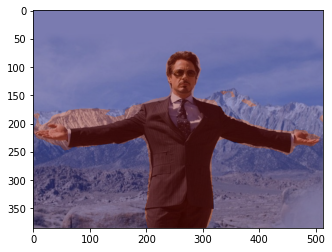

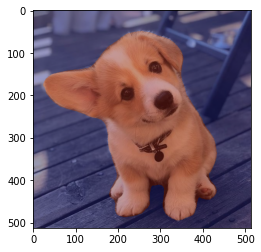

In [5]:
#######################################
### Show semantic segmentation mask ###
#######################################
def showSemSegMask(img_resized, seg_map, obj_label):
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == obj_label, obj_label, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

    return img_mask

img_rdj_mask = showSemSegMask(img_rdj_resized, rdj_seg_map, rdj_label)
img_pup_mask = showSemSegMask(img_pup_resized, pup_seg_map, pup_label)

In [6]:
 rdj_label

15

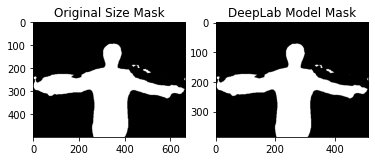

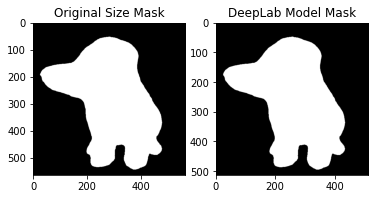

In [7]:
#####################
### Original size ###
#####################
def resize2orig(img_mask, img_orig):
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')
    plt.show()

    return img_mask_up
    
img_rdj_mask_up = resize2orig(img_rdj_mask, img_rdj_orig)
img_pup_mask_up = resize2orig(img_pup_mask, img_pup_orig)

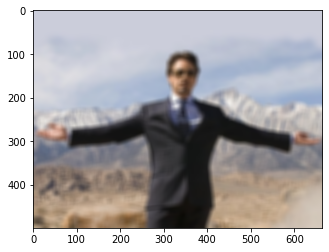

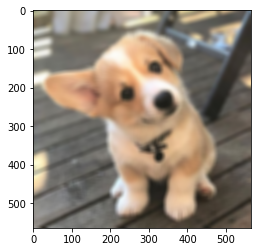

In [8]:
###########################
### Original blur image ###
###########################
def showBlur(img_orig):
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show() # img_orig_blur 결과

    return img_orig_blur

img_rdj_orig_blur = showBlur(img_rdj_orig)
img_pup_orig_blur = showBlur(img_pup_orig)

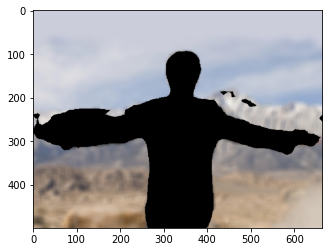

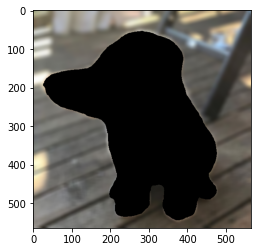

In [9]:
#############################
### Background blur image ###
#############################
def showBlurBackground(img_mask_up, img_orig_blur):
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    return img_mask_color, img_bg_blur

img_rdj_mask_color, img_rdj_bg_blur = showBlurBackground(img_rdj_mask_up, img_rdj_orig_blur)
img_pup_mask_color, img_pup_bg_blur = showBlurBackground(img_pup_mask_up, img_pup_orig_blur)

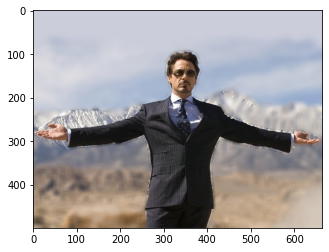

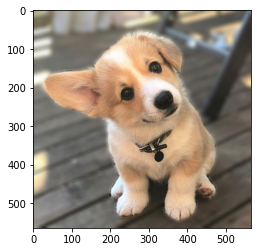

In [10]:
########################
### Composite image ###
########################
def blurComposite(img_mask_color, img_orig, img_bg_blur):
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

    return img_concat

img_rdj_concat = blurComposite(img_rdj_mask_color, img_rdj_orig, img_rdj_bg_blur)
img_pup_concat = blurComposite(img_pup_mask_color, img_pup_orig, img_pup_bg_blur)

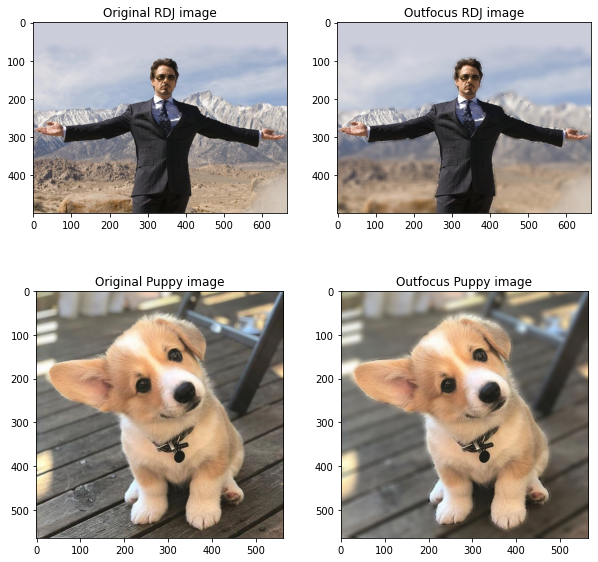

In [11]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax1.imshow(cv2.cvtColor(img_rdj_orig, cv2.COLOR_BGR2RGB))
ax1.set_title('Original RDJ image')

ax2 = fig.add_subplot(2,2,2)
ax2.imshow(cv2.cvtColor(img_rdj_concat, cv2.COLOR_BGR2RGB))
ax2.set_title('Outfocus RDJ image')

ax3 = fig.add_subplot(2,2,3)
ax3.imshow(cv2.cvtColor(img_pup_orig, cv2.COLOR_BGR2RGB))
ax3.set_title('Original Puppy image')

ax4 = fig.add_subplot(2,2,4)
ax4.imshow(cv2.cvtColor(img_pup_concat, cv2.COLOR_BGR2RGB))
ax4.set_title('Outfocus Puppy image')

plt.show()

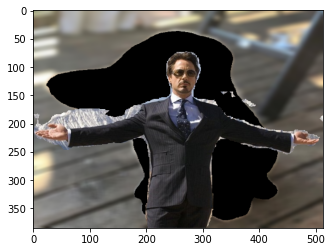

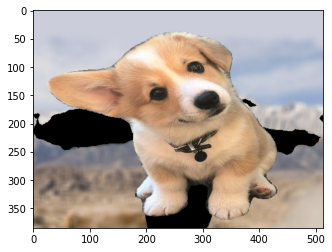

In [12]:
#################
### Chromakey ###
#################
target_height = min(img_rdj_resized.shape[0], img_pup_resized.shape[0])
target_width = min(img_rdj_resized.shape[1], img_pup_resized.shape[1])
target_size=(target_width, target_height)

img_rdj_orig_resized = cv2.resize(img_rdj_orig, target_size)
img_rdj_bg_blur_resized = cv2.resize(img_rdj_bg_blur, target_size)
img_rdj_mask_color_resize = cv2.resize(img_rdj_mask_color, target_size)

img_pup_orig_resized = cv2.resize(img_pup_orig, target_size)
img_pup_bg_blur_resized = cv2.resize(img_pup_bg_blur, target_size)
img_pup_mask_color_resize = cv2.resize(img_pup_mask_color, target_size)

img_rdj_pup_concat = blurComposite(img_rdj_mask_color_resize, img_rdj_orig_resized, img_pup_bg_blur_resized)

img_pup_rdj_concat = blurComposite(img_pup_mask_color_resize, img_pup_orig_resized, img_rdj_bg_blur_resized)


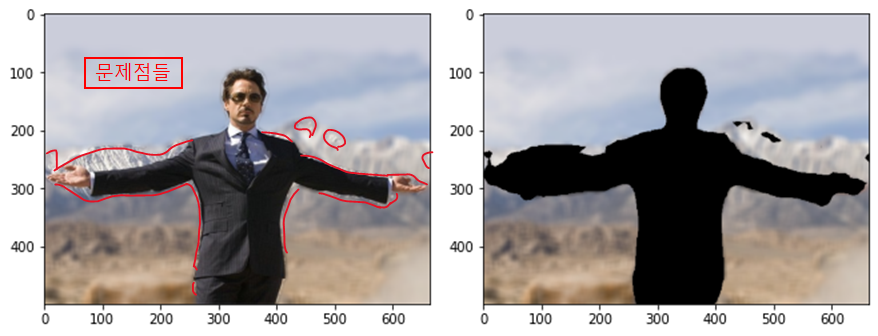

In [13]:
from IPython.display import Image
Image('/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/result_rdj_3.png')

위의 문제점을 해결하기 위한 방법

- Use 3D Depth (Stereo) Camera
    - 한 장면에 대해서 stereo image를 가지고 있다면, 우리는 그 두 장의 이미지로부터 disparity 얻을 수 있고,
    - disparities, focal lengths, baseline을 가지고 triangulation 계산을 통하여 depth 값 계산 가능
    - 각 픽셀에 대한 depth 정보를 알고 있다면, sementic segmentation mask 과정에서 객체와 배경을 구분 할 때 depth 값이 차이가 많이나는 지점을 경계로 판단하여 조금 더 경계를 명확히 표현 할 수 있을 것이라 생각됨
    - f는 focal length로 이미지와 카메라 렌즈 사이 거리


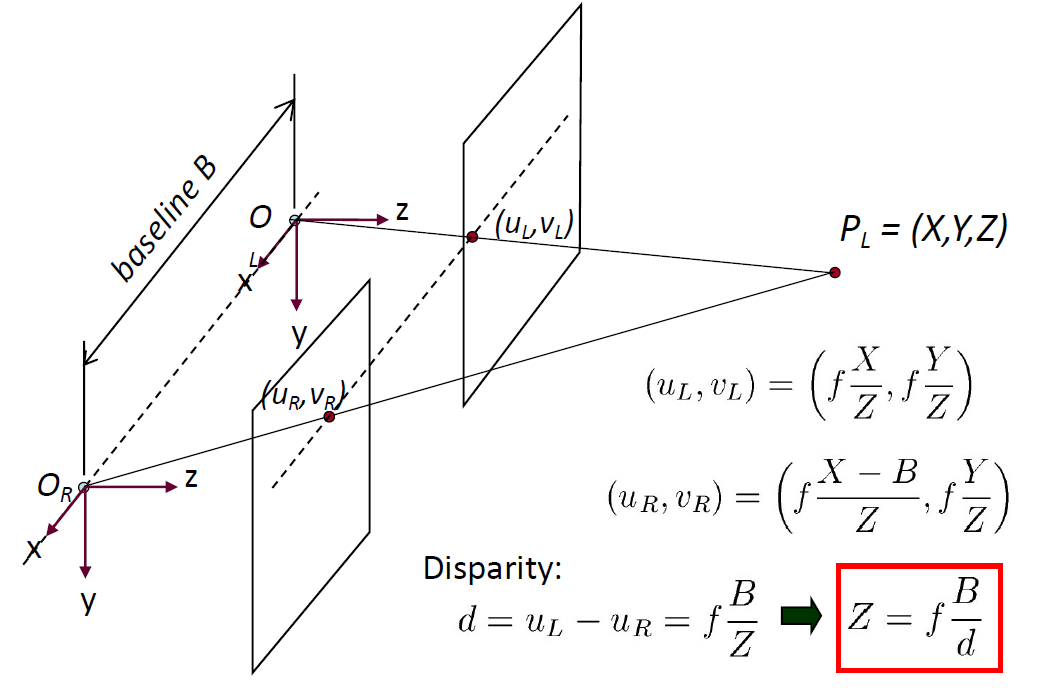

In [14]:
Image('/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/depthDerivations.png') # Figure from D. Lowe

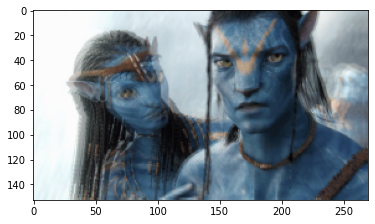

In [15]:
#####################
### Stereo images ###
#####################
from PIL import Image
img_l = cv2.imread('/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/avatar_l.png')
img_r = cv2.imread('/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/avatar_r.png')
img_l = cv2.cvtColor(img_l, cv2.COLOR_RGB2BGR)
img_r = cv2.cvtColor(img_r, cv2.COLOR_RGB2BGR)
plt.imshow(img_l)
plt.imshow(img_r, alpha=0.5)
plt.show()

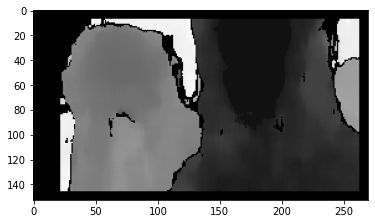

In [16]:
#################
### Disparity ###
#################
img_l = cv2.imread('/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/avatar_l.png',0)
img_r = cv2.imread('/content/drive/MyDrive/AIFFEL/Exploration/human_segmentation/avatar_r.png',0)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img_l,img_r)
plt.imshow(disparity,'gray')
plt.show()

**결론**    
- 아웃포커싱 효과가 적용된 인물모드 사진과 강아지 사진, 그리고 두 사진의 배경을 서로 바꿔서 적용해본 크로마키사진이 결과로 나옴
- 인물사진에서 사람의 몸과 배경의 구분이 명확하지 않는 문제점이 존재하였으며, 해당 부분을 사진에 표시함
- 추가적인 depth 정보를 활용한다면 배경과 인물을 구분하는 경계를 조금 더 뚜렷하게 표현 가능할 것이라고 판단됨